# Sunspot numbers

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

import torch
import torch.nn as nn
import torch.nn.functional as F

::

    Number of Observations - 309 (Annual 1700 - 2008)
    Number of Variables - 1
    Variable name definitions::

        SUNACTIVITY - Number of sunspots for each year

    The data file contains a 'YEAR' variable that is not returned by load.



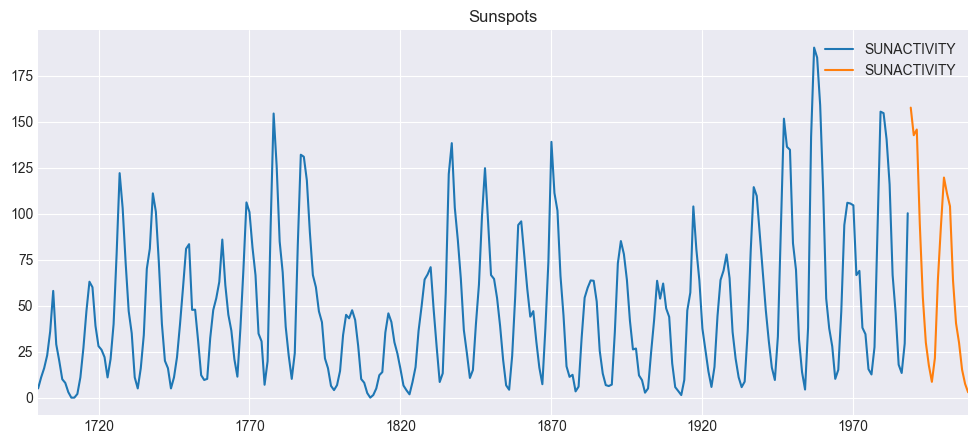

In [2]:
print(sm.datasets.sunspots.NOTE)
data = sm.datasets.sunspots.load_pandas().data

data.index = pd.Index(sm.tsa.datetools.dates_from_range("1700", "2008"))
data.index.freq = data.index.inferred_freq
del data["YEAR"]

tst_size = 20
trn, tst = data[:-tst_size], data[-tst_size:]

ax = trn.plot(title="Sunspots", label='trn', figsize=(12,5))
tst.plot(label='tst', ax=ax)
plt.legend()
plt.show()

## ARIMA

ADF Statistic: -2.385237524049347
p-value: 0.14594643147742514
Critical Values:
	1%: -3.453922368485787
	5%: -2.871918329081633
	10%: -2.5723001147959184


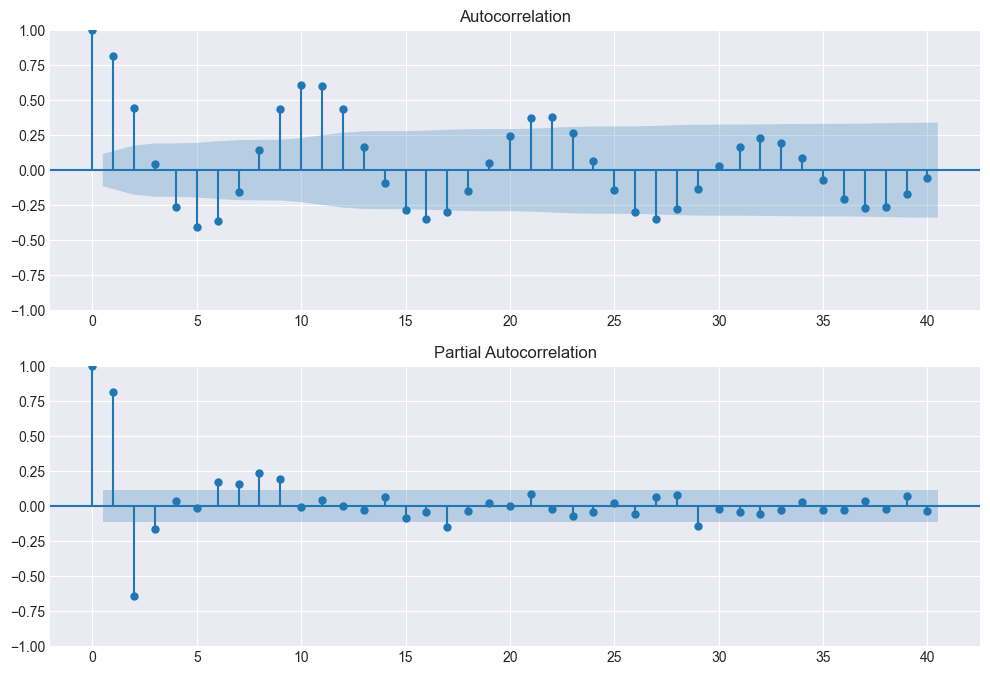

In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(trn.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(trn.values.squeeze(), lags=40, ax=ax2)

adf = adfuller(trn)
print('ADF Statistic: {}'.format(adf[0]))
print('p-value: {}'.format(adf[1]))
print('Critical Values:')
for key, value in adf[4].items():
  print('\t{}: {}'.format(key, value))

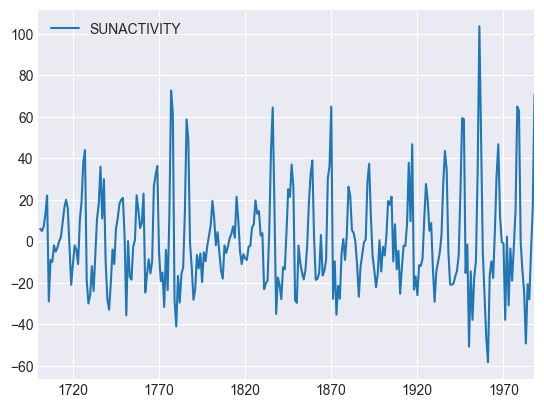

In [4]:
trn.diff(1).plot(label="Diff(1)")
plt.show()

ADF Statistic: -14.074135512450217
p-value: 2.905013790471284e-26
Critical Values:
	1%: -3.453922368485787
	5%: -2.871918329081633
	10%: -2.5723001147959184


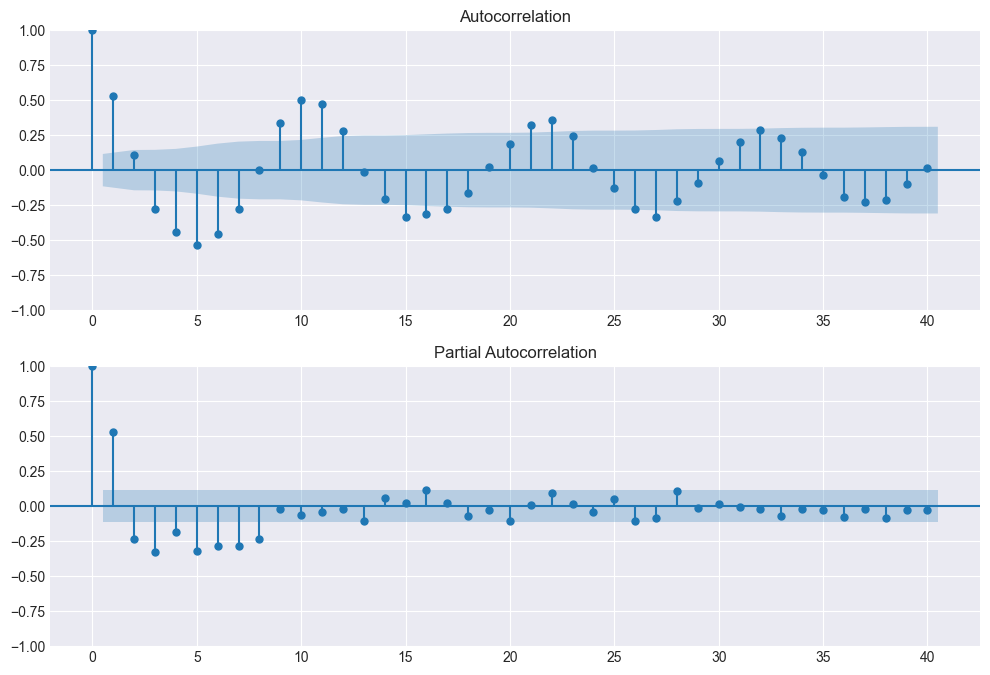

In [5]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(trn.diff(1).dropna().values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(trn.diff(1).dropna().values.squeeze(), lags=40, ax=ax2)

adf = adfuller(trn.diff(1).dropna())
print('ADF Statistic: {}'.format(adf[0]))
print('p-value: {}'.format(adf[1]))
print('Critical Values:')
for key, value in adf[4].items():
  print('\t{}: {}'.format(key, value))

최종후보 : ARIMA(9,0,0), ARIMA(8,1,0)

In [6]:
def mape(y_pred, y_true):
  return (np.abs(y_pred - y_true)/y_true).mean() * 100

def mae(y_pred, y_true):
  return np.abs(y_pred - y_true).mean()

In [7]:
from statsmodels.tsa.arima.model import ARIMA

trn, tst = data.SUNACTIVITY[:-tst_size], data.SUNACTIVITY[-tst_size:]
arma_mod90 = ARIMA(trn, order=(9,0,0)).fit() # AR(9)

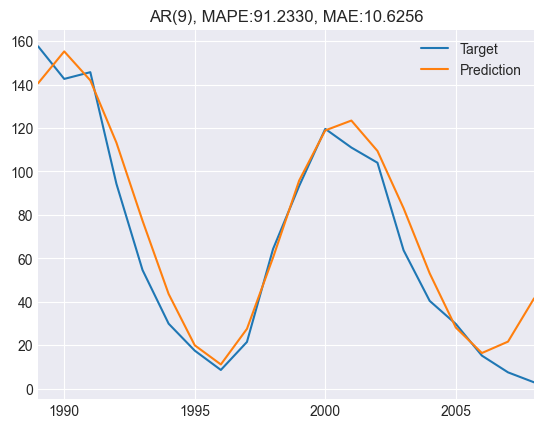

In [8]:
prd = arma_mod90.predict("1989", "2008", dynamic=True)

plt.title(f"AR(9), MAPE:{mape(prd, tst):.4f}, MAE:{mae(prd, tst):.4f}")
tst.plot(label="Target")
prd.plot(label=f"Prediction")
plt.legend()
plt.show()

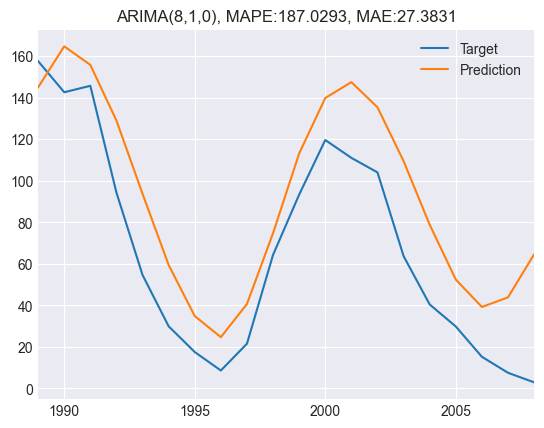

In [9]:
arima_mod810 = ARIMA(trn, order=(8,1,0)).fit() # ARIMA(8,1,0)

prd = arima_mod810.predict("1989", "2008", dynamic=True)

plt.title(f"ARIMA(8,1,0), MAPE:{mape(prd, tst):.4f}, MAE:{mae(prd, tst):.4f}")
tst.plot(label="Target")
prd.plot(label="Prediction")
plt.legend()
plt.show()

- AR(9), MAEP:91.23, MAE:10.62

# Neural Network

In [27]:
class TimeSeriesDataset(torch.utils.data.Dataset):
  def __init__(self, ts:np.array, lookback_size:int, forecast_size:int):
    self.lookback_size = lookback_size
    self.forecast_size = forecast_size
    self.data = ts

  def __len__(self):
    return len(self.data) - self.lookback_size - self.forecast_size + 1

  def __getitem__(self, i):
    idx = (i+self.lookback_size)
    look_back = self.data[i:idx]
    forecast = self.data[idx:idx+self.forecast_size]

    return look_back, forecast

In [28]:
from sklearn.preprocessing import MinMaxScaler

lookback_size = 9
forecast_size = 4

scaler = MinMaxScaler()
trn_scaled = scaler.fit_transform(data[:-tst_size].to_numpy(dtype=np.float32)).flatten()
tst_scaled = scaler.transform(data[-tst_size-lookback_size:].to_numpy(dtype=np.float32)).flatten()

trn_ds = TimeSeriesDataset(trn_scaled, lookback_size, forecast_size)
tst_ds = TimeSeriesDataset(tst_scaled, lookback_size, forecast_size)

trn_dl = torch.utils.data.DataLoader(trn_ds, batch_size=32, shuffle=True)
tst_dl = torch.utils.data.DataLoader(tst_ds, batch_size=tst_size, shuffle=False)

In [29]:
x, y = next(iter(tst_dl))

x.shape, y.shape

(torch.Size([17, 9]), torch.Size([17, 4]))

In [30]:
class Net(nn.Module):
  def __init__(self, d_in, d_out, d_hidden, activation=F.relu):
    super().__init__()
    self.lin1 = nn.Linear(d_in, d_hidden)
    self.lin2 = nn.Linear(d_hidden, d_out)
    self.activation = activation

  def forward(self, x):
    x = self.lin1(x)
    x = self.activation(x)
    x = self.lin2(x)
    return F.sigmoid(x)

In [31]:
def mape(y_pred, y_true):
  return (torch.abs(y_pred - y_true)/y_true).mean() * 100

def mae(y_pred, y_true):
  return torch.abs(y_pred - y_true).mean()

In [32]:
from tqdm.auto import trange

net = Net(9, 4, 512)
net.cuda()

optim = torch.optim.AdamW(net.parameters(), lr=0.0001)

pbar = trange(2000)
for i in pbar:
  net.train()
  trn_loss = .0
  for x, y in trn_dl:
    x, y = x.cuda(), y.cuda()
    p = net(x)
    optim.zero_grad()
    loss = F.mse_loss(p, y)
    loss.backward()
    optim.step()
    trn_loss += loss.item()*len(y)
  trn_loss = trn_loss/len(trn_ds)

  net.eval()
  with torch.inference_mode():
    x, y = next(iter(tst_dl))
    x, y = x.cuda(), y.cuda()
    p = net(x)
    tst_loss = F.mse_loss(p,y)
    tst_mape = mape(p,y)
    tst_mae = mae(p,y)
  pbar.set_postfix({'loss':trn_loss, 'tst_loss':tst_loss.item(), 'tst_mape':tst_mape.item(), 'tst_mae':tst_mae.item()})

  0%|          | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [16]:
net.eval()
with torch.inference_mode():
  x, y = next(iter(tst_dl))
  x, y = x.cuda(), y.cuda()
  p = net(x)

def mape(y_pred, y_true):
  return (np.abs(y_pred - y_true)/y_true).mean() * 100

def mae(y_pred, y_true):
  return np.abs(y_pred - y_true).mean()

y = scaler.inverse_transform(y.cpu())
p = scaler.inverse_transform(p.cpu())

y = np.concatenate([y[:,0], y[-1,1:]])
p = np.concatenate([p[:,0], p[-1,1:]])

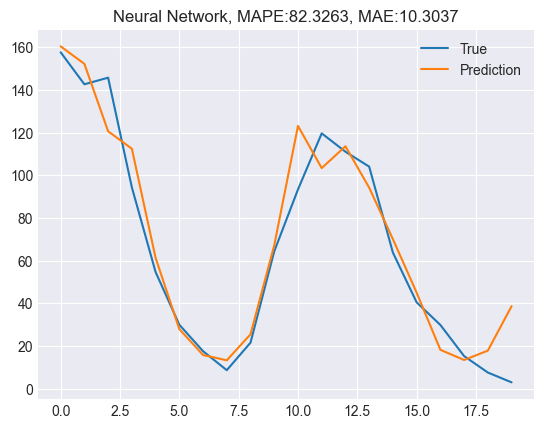

In [17]:
plt.title(f"Neural Network, MAPE:{mape(p,y):.4f}, MAE:{mae(p,y):.4f}")
plt.plot(range(tst_size), y, label="True")
plt.plot(range(tst_size), p, label="Prediction")
plt.legend()
plt.show()

- AR(9)
  - MAEP: 91.23
  - MAE: 10.62
- NN(9, 4, 512)
  - MAPE: 82.36
  - MAE: 9.81

### Multi-channel

In [22]:
m_data = data.copy()
m_data['rolling_mean'] = data.SUNACTIVITY.rolling(11).mean()
m_data

,SUNACTIVITY,rolling_mean
1700-12-31,5.0,NaN
1701-12-31,11.0,NaN
1702-12-31,16.0,NaN
1703-12-31,23.0,NaN
1704-12-31,36.0,NaN
...,...,...
2004-12-31,40.4,61.254545
2005-12-31,29.8,61.245455
2006-12-31,15.2,61.036364
2007-12-31,7.5,60.936364


In [19]:
m_data = m_data.dropna()

lookback_size = 9
forecast_size = 4

scaler = MinMaxScaler()
trn_scaled = scaler.fit_transform(m_data[:-tst_size].to_numpy(dtype=np.float32))
tst_scaled = scaler.transform(m_data[-tst_size-lookback_size:].to_numpy(dtype=np.float32))

trn_ds = TimeSeriesDataset(trn_scaled, lookback_size, forecast_size)
tst_ds = TimeSeriesDataset(tst_scaled, lookback_size, forecast_size)

trn_dl = torch.utils.data.DataLoader(trn_ds, batch_size=32, shuffle=True)
tst_dl = torch.utils.data.DataLoader(tst_ds, batch_size=tst_size, shuffle=False)

<Axes: >

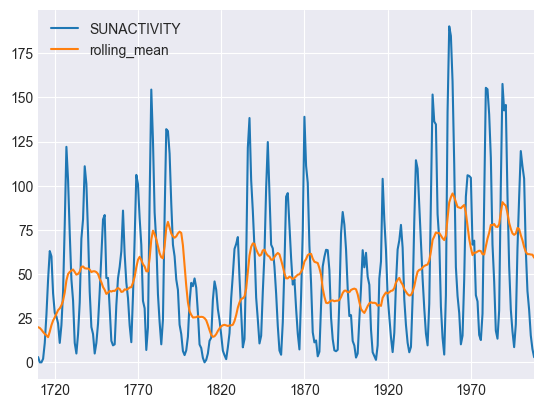

In [20]:
m_data.plot()

In [21]:
x, y = next(iter(trn_dl))

In [22]:
x.shape # Batch, Length, Channel

torch.Size([32, 9, 2])

In [23]:
y.shape

torch.Size([32, 4, 2])

In [24]:
class NetMulti(nn.Module):
  def __init__(self, d_in, d_out, d_hidden, c_in, activation=F.relu):
    super().__init__()
    self.lin1 = nn.Linear(d_in*c_in, d_hidden)
    self.lin2 = nn.Linear(d_hidden, d_out)
    self.activation = activation

  def forward(self, x):
    x = x.flatten(1)    # (B, d_in * c_in)
    x = self.lin1(x)    # (B, d_hidden)
    x = self.activation(x)
    x = self.lin2(x)    # (B, d_out)
    return F.sigmoid(x)

In [25]:
from tqdm.auto import trange

net = NetMulti(9, 4, 512, 2)
net.cuda()

optim = torch.optim.AdamW(net.parameters(), lr=0.0001)

pbar = trange(2000)
for i in pbar:
  net.train()
  trn_loss = .0
  for x, y in trn_dl:
    x, y = x.flatten(1).cuda(), y[:,:,0].cuda()   # (32, 18), (32, 4)
    p = net(x)
    optim.zero_grad()
    loss = F.mse_loss(p, y)
    loss.backward()
    optim.step()
    trn_loss += loss.item()*len(y)
  trn_loss = trn_loss/len(trn_ds)

  net.eval()
  with torch.inference_mode():
    x, y = next(iter(tst_dl))
    x, y = x.flatten(1).cuda(), y[:,:,0].cuda()
    p = net(x)
    tst_loss = F.mse_loss(p,y)
  pbar.set_postfix({'loss':trn_loss, 'tst_loss':tst_loss.item()})

  0%|          | 0/2000 [00:00<?, ?it/s]

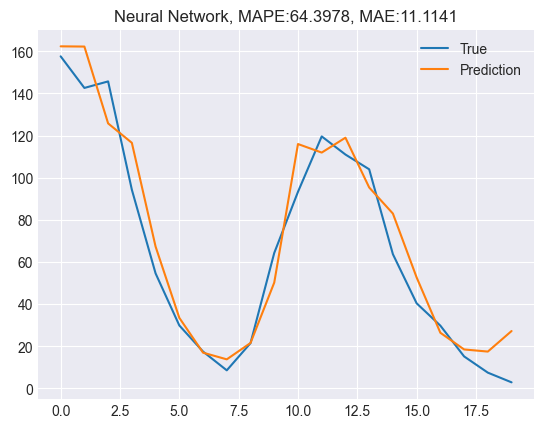

In [26]:
net.eval()
with torch.inference_mode():
  x, y = next(iter(tst_dl))
  x, y = x.flatten(1).cuda(), y[:,:,0].cuda()
  p = net(x)

y = y.cpu()/scaler.scale_[0] + scaler.min_[0]
p = p.cpu()/scaler.scale_[0] + scaler.min_[0]

y = np.concatenate([y[:,0], y[-1,1:]])
p = np.concatenate([p[:,0], p[-1,1:]])

plt.title(f"Neural Network, MAPE:{mape(p,y):.4f}, MAE:{mae(p,y):.4f}")
plt.plot(range(tst_size), y, label="True")
plt.plot(range(tst_size), p, label="Prediction")
plt.legend()
plt.show()

- AR(9)
  - MAEP: 91.23
  - MAE: 10.62
- NN(9, 4, 512)
  - MAPE: 82.36
  - MAE: 9.81
- NNMulti(9,4,512,2)
  - MAPE: 61.09
  - MAE: 11.02

## Transformer (PatchTST)

In [18]:
class PatchTSDataset(torch.utils.data.Dataset):
  def __init__(self, ts:np.array, patch_size:int=4, n_token:int=6):
    self.patch_size = patch_size
    self.n_patch = 4
    self.n_token = n_token
    self.window_size = int(patch_size * self.n_patch * n_token / 2)
    self.forecast_size = patch_size
    self.data = ts

  def __len__(self):
    return len(self.data) - self.window_size - self.forecast_size + 1

  def __getitem__(self, i):
    look_back = self.data[i:(i+self.window_size)]
    look_back = np.concatenate([look_back] + [look_back[-self.patch_size:]] * int(self.n_patch / 2))
    x = np.array([look_back[i*int(self.patch_size*self.n_patch/2):(i+2)*int(self.patch_size*self.n_patch/2)] for i in range(self.n_token)])

    y = self.data[(i+self.window_size):(i+self.window_size+self.forecast_size)]
    return x, y

In [19]:
patch_size, n_patch, n_token = 4, 4, 6
window_size = int(patch_size * n_patch * n_token / 2)

scaler = MinMaxScaler()
trn_scaled = scaler.fit_transform(data[:-tst_size].to_numpy(dtype=np.float32)).flatten()
tst_scaled = scaler.transform(data[-tst_size-window_size:].to_numpy(dtype=np.float32)).flatten()

trn_ds = PatchTSDataset(trn_scaled, 4, 6)
tst_ds = PatchTSDataset(tst_scaled, 4, 6)

trn_dl = torch.utils.data.DataLoader(trn_ds, batch_size=32, shuffle=True)
tst_dl = torch.utils.data.DataLoader(tst_ds, batch_size=tst_size, shuffle=False)

In [23]:
scaler2 = MinMaxScaler()

trn2_scaled = scaler2.fit_transform(m_data['rolling_mean'][:-tst_size].to_numpy(dtype=np.float32).reshape(-1,1)).flatten()

trn2_ds = PatchTSDataset(trn2_scaled, 4, 6)

trn_ds = torch.utils.data.ConcatDataset([trn_ds, trn2_ds])

trn_dl = torch.utils.data.DataLoader(trn_ds, batch_size=32, shuffle=True)

In [24]:
x, y = next(iter(trn_dl))
x.shape, y.shape

(torch.Size([32, 6, 16]), torch.Size([32, 4]))

In [25]:
class PatchTST(nn.Module):
  def __init__(self, n_token, input_dim, model_dim, num_heads, num_layers, output_dim):
    super(PatchTST, self).__init__()
    self.patch_embedding = nn.Linear(input_dim, model_dim)    # Input Embedding
    self._pos = torch.nn.Parameter(torch.randn(1,1,model_dim))  # Positional Embedding

    encoder_layers = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, batch_first=True)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

    self.output_layer = nn.Linear(model_dim * n_token, output_dim)

  def forward(self, x):
    # x shape: (batch_size, n_token, token_size)
    x = self.patch_embedding(x)   # (batch_size, n_token, model_dim)
    x = x + self._pos
    x = self.transformer_encoder(x)   # (batch_size, n_token, model_dim)
    x = x.view(x.size(0), -1)       # (batch_size, n_token * model_dim)
    output = self.output_layer(x)   # (batch_size, out_dim =4 patch_size == 4)
    return F.sigmoid(output)

In [26]:
model = PatchTST(n_token, patch_size * n_patch, 512, 8, 4, patch_size)
model.cuda()

optim = torch.optim.AdamW(model.parameters(), lr=0.0001)

pbar = trange(500)
for _ in pbar:
  model.train()
  trn_loss = 0.
  for x,y in trn_dl:
    x, y = x.cuda(), y.cuda()
    p = model(x)
    optim.zero_grad()
    loss = F.mse_loss(p, y)
    loss.backward()
    optim.step()
    trn_loss += loss.item()*len(x)
  trn_loss = trn_loss / len(trn_ds)

  model.eval()
  with torch.inference_mode():
    x, y = next(iter(tst_dl))
    x, y = x.cuda(), y.cuda()
    p = model(x)
    tst_loss = F.mse_loss(p,y)
  pbar.set_postfix({'loss':trn_loss, 'tst_loss':tst_loss.item()})

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

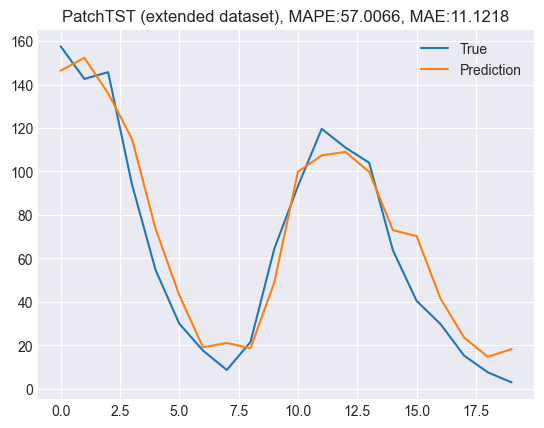

In [33]:
model.eval()
with torch.inference_mode():
  x, y = next(iter(tst_dl))
  x, y = x.cuda(), y.cuda()
  p = model(x)

y = scaler.inverse_transform(y.cpu())
p = scaler.inverse_transform(p.cpu())

y = np.concatenate([y[:,0], y[-1,1:]])
p = np.concatenate([p[:,0], p[-1,1:]])

plt.title(f"PatchTST (extended dataset), MAPE:{mape(p,y):.4f}, MAE:{mae(p,y):.4f}")
plt.plot(range(tst_size), y, label="True")
plt.plot(range(tst_size), p, label="Prediction")
plt.legend()
plt.show()

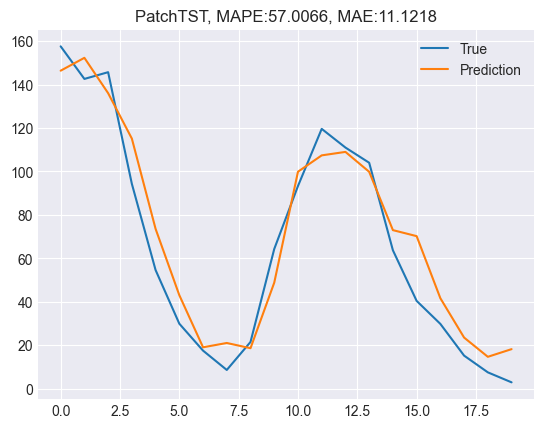

In [34]:
model.eval()
with torch.inference_mode():
  x, y = next(iter(tst_dl))
  x, y = x.cuda(), y.cuda()
  p = model(x)

y = scaler.inverse_transform(y.cpu())
p = scaler.inverse_transform(p.cpu())

y = np.concatenate([y[:,0], y[-1,1:]])
p = np.concatenate([p[:,0], p[-1,1:]])

plt.title(f"PatchTST, MAPE:{mape(p,y):.4f}, MAE:{mae(p,y):.4f}")
plt.plot(range(tst_size), y, label="True")
plt.plot(range(tst_size), p, label="Prediction")
plt.legend()
plt.show()

- AR(9)
  - MAEP: 91.23
  - MAE: 10.62
- NN(9, 4, 512)
  - MAPE: 82.36
  - MAE: 9.81
- NNMulti(9,4,512,2)
  - MAPE: 61.09
  - MAE: 11.02
- PatchTST
  - MAPE: 65.59
  - MAE: 11.47
- PatchTST (scaling)
  - MAPE: 67.55
  - MAE: 10.86
- PatchTST (extended dataset)
  - MAPE: 44.54
  - MAE: 10.25